<img src='https://github.com/LinkedEarth/Logos/blob/master/Pyleoclim/PYLEOCLIM_logo_HORZ-01.png?raw=true' width="800">

# Using Surrogate Series with Pyleoclim

by _[Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), USC_

## Preamble

This tutorial gives an overview of the `SurrogateSeries` class: we explain general concept about surrogates, show how to generate and visualize them with `Pyleoclim`, and show how use them to assess the significance of various analyses.


### Goals

- Learn general concepts about surrogates
- Learn how to generate and visualize them with `Pyleoclim`.
    * `from_series` (show how to obtain parameters)
    * `from_param`
- Learn how use them to assess the significance of various analyses
 
**Reading Time: 10 min**

### Keywords
Surrogates, Autoregressive model, Long-memory models, Phase scrambling

### Pre-requisites
Some timeseries analysis, ideally 

### Relevant Packages
pyleoclim, pandas, matplotlib, numpy

## Motivation
We start with the Big Question: why? **Why on Earth would Earth Scientists need surrogate series, if they have real (observation-based) series?** The answer is simple: significance. In many areas of the sciences, we compute some kind of number (a "statistic") from the data and we ask: is this notable or not? What we usually mean by that is: "How likely was this result, or something as anomalous as this result,  to have arisen under some specified **null hypothesis**. 

To be more specific: how likely would you be to observe this result if your data had been swapped with *data that have specific characteristics, but are otherwise random*? That's what surrogate data are: random data that can be used as a [null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis) for what we are trying to test. However, there are many ways to be "random". Indeed, surrogate data can be:
1. **generated by Gaussian white noise** (the most common null hypothesis used in science, though not always the most appropriate). 
1. **generated by another, more complex parametric model**, for instance an [autoregressive or moving-average model](https://en.wikipedia.org/wiki/Autoregressive_moving-average_model). If you are new to such models, we strongly advise learning a bit about them (for instance, in Chapter 8 of [this free book](https://figshare.com/articles/book/Data_Analysis_in_the_Earth_Environmental_Sciences/1014336/11)). In essence, they use stochastic (random) processes and a few parameters to capture the key properties of observed timeseries, e.g. their memory (aka persistence).
1. **data obtained by perturbing the original dataset** in ways that modify certain key characteristics, but preserve others. Example of this include the [bootstrap](https://doi.org/10.1201/9780429246593), block bootstrap, [maximum-entropy bootstrap](http://dx.doi.org/10.1016/j.asieco.2006.09.001), and [phase scrambling](https://doi.org/10.1103/PhysRevLett.73.951).  The last method, in turn is rather common in climate science (e.g. [here](http://dx.doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2) and [here](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023GL106585).)
 
  The first two are examples of **parametric** surrogates: they are generated by mathematical models (simple or complex) that have in common an expression of the series values as a function of some parameters. The third kind are **non-parametric** surrogates: they are obtained by manipulating the original data, but involve no such parameters. 

  Both types of surrogates are allowed in `Pyleoclim`, and have different advantages and disadvantages.  
  

## Data description

- The [Southern Oscillation Index](https://www.ncei.noaa.gov/access/monitoring/enso/soi) 
- The [LR04 benthic stack](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071)

Let us first load necessary packages:

In [1]:
import pyleoclim as pyleo
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## Parametric Surrogates
 The first null (Gaussian white noise) is common because it is convenient, and has been so for over 150 years, lending itself to all kinds of analytical results. That is what most introductory statistics textbooks cover. However, what is easy is seldom what is right, and nowhere is that more true than in the paleosciences. For instance, processes like bioturbation (sediments), karst mixing (caves), or isotope diffusion (ice cores) impart memory, so the behavior is no longer white. That is, consecutive values are no longer independent, which undermines 95% of common statistical methods, which have it as their most bedrock assumption that data are independent (and identically distributed). This means that those methods or tests are not applicable to such data.

To circumvent this problem, one wants surrogates that are simple enough to serve as plausible nulls, but exhibit some kind of memory. Two such models are currently implemented in `Pyleoclim`:
- [AR(1) surrogates](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process): this an example of "short-memory" processes, where autocorrelation decays exponentially. 
- [Colored Noise surrogates](https://en.wikipedia.org/wiki/Colors_of_noise) have a power spectrum $S(f)$ in the form of a power law $f^{-\beta}$, with $\beta$ a constant that is frequently near unity or larger (see [Zhu et al (2019)](https://doi.org/10.1073/pnas.1809959116)). The autocorrelation also behaves as a power law, of the form $\gamma(t) = t^{-\beta -1}$. 
 
There are two ways of generating such surrogates in `Pyleoclim`: 
1. using given parameters (see `from_param()`)
2. emulating an existing series (see `from_series()`)

In both cases, we first need to request a `SurrogateSeries` object, specify what method we'll use for that, and how many surrogates we want. For instance, to set up 10 AR(1) surrogates:

In [2]:
ar1 = pyleo.SurrogateSeries(method='ar1sim', number=20) 
type(ar1)

pyleoclim.core.surrogateseries.SurrogateSeries

Next, we specify the model parameters (e-folding time $\tau$, noise variance $\sigma^2$), and how many time steps we want, and plot the result

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'AR(1) synthetic series ($\\tau=2,\\sigma^2=2$)'}, xlabel='Time [years CE]', ylabel='value'>)

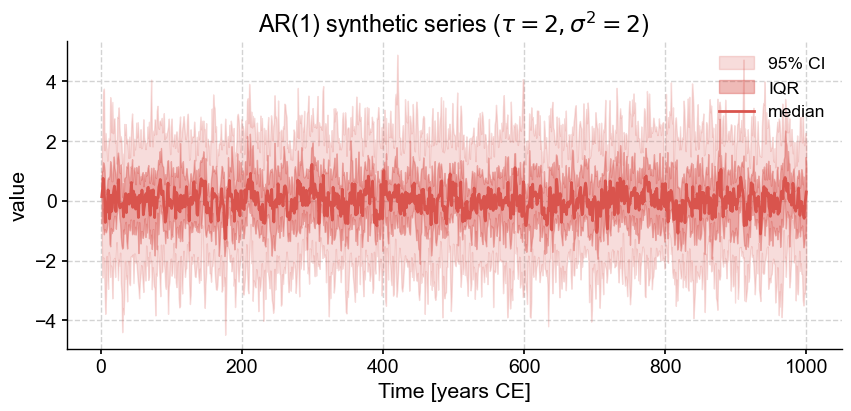

In [3]:
T=1000
ar1.from_param(length=T, param = [2,2])
ar1.plot_envelope(title=rf'AR(1) synthetic series ($\tau={2},\sigma^2={2}$)')

The ensemble is small ($n=20$) so the mean is not flat. With a larger, ensemble, the mean should flatline:


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'AR(1) synthetic series ($\\tau=2,\\sigma^2=2$)'}, xlabel='Time [years CE]', ylabel='value'>)

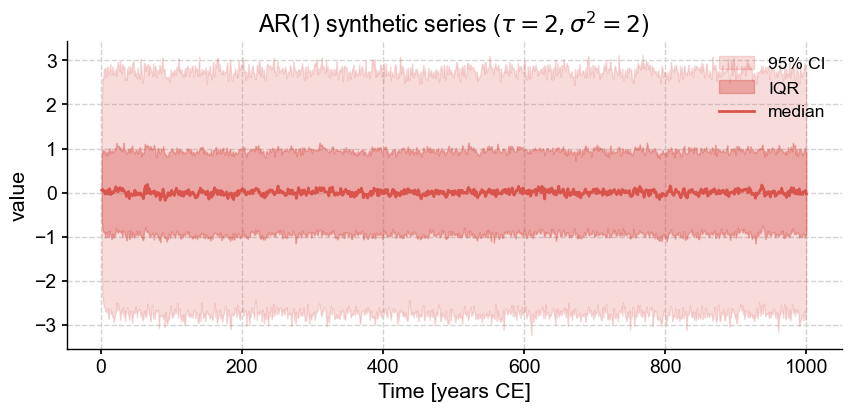

In [4]:
ar1_L = pyleo.SurrogateSeries(method='ar1sim', number=1000) 
ar1_L.from_param(length=T, param = [2,2])
ar1_L.plot_envelope(title=rf'AR(1) synthetic series ($\tau={2},\sigma^2={2}$)')

That is indeed what we observe, and it is a reminder that small ensembles are marred by sampling artifacts: there may appear to be some structure, when in fact it disappears with a large enough sample. Note that `SurrogateSeries` is a child of [EnsembleSeries](./L0_basic_MSES_manipulation.md), so it naturally inherits its attributes, including the [plot_envelope()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensembleseries.EnsembleSeries.plot_envelope) function used to visualize this result. Another useful one is [plot_traces()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensembleseries.EnsembleSeries.plot_traces). For instance, to plot 5 random traces from this ensemble, do:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'AR(1) surrogates (MoM)'}, xlabel='Time [years CE]', ylabel='value'>)

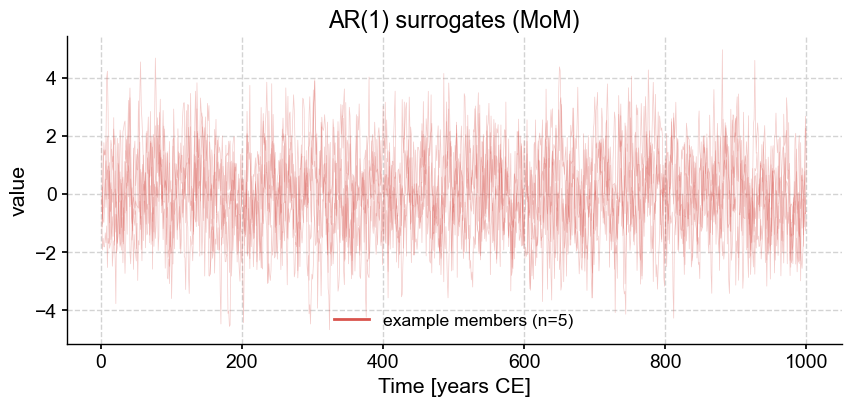

In [5]:
ar1_L.plot_traces(num_traces=5)

To generate a pink noise series (aka "shot noise" or "[flicker noise](https://en.wikipedia.org/wiki/Flicker_noise)", characterized by a spectrum that goes as $1/f$), simply use the `CN` method with a slope parameter of 1.0:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Pink noise  ($\\beta=1.0$)'}, xlabel='Time [years CE]', ylabel='value'>)

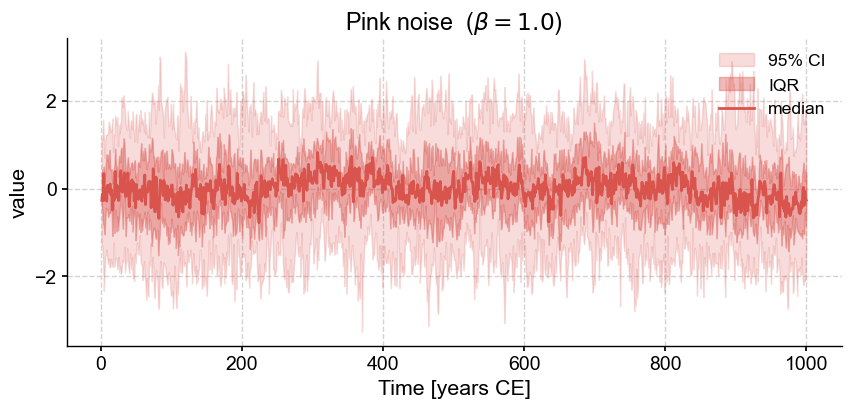

In [6]:
pink = pyleo.SurrogateSeries(method='CN', number=20) # define noise type
pink.from_param(length=T, param = [1.0]) # sample from model, given parameters
pink.plot_envelope(title=rf'Pink noise  ($\beta=1.0$)') # plot the result

It's hard to tell what else might be difference by staring at these ensemble plots. Let's compare the spectral densities of these two models:

Performing spectral analysis on individual series: 100%|██████████| 20/20 [00:00<00:00, 129.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Performing spectral analysis on individual series: 100%|██████████| 20/20 [00:00<00:00, 151.69it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Pink noise')

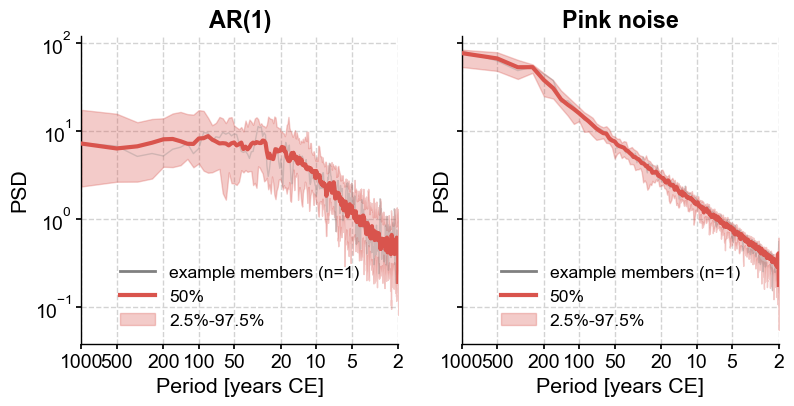

In [7]:
fig, axs = plt.subplots(1,2,figsize=(9,4),sharex=True, sharey=True)
axs = axs.flatten()

for i, model in enumerate([ar1,pink]):
    psd = model.standardize().spectral(method='mtm')
    psd.plot_envelope(ax=axs[i],members_plot_num=1, lgd_kwargs={'loc':'lower center'})
axs[0].set_title('AR(1)', fontweight='bold')
axs[1].set_title('Pink noise', fontweight='bold')

This is the main difference between these types of noise : an AR(1) model has a spectrum that flattens at long periods (see the thick red curve on the left, flattening at periods ~20y with this choice of parameters) whereas the flicker noise has power that keeps growing with frequency. Here it flattens at periods of ~200y, but if we generated longer series, it would keep growing indefinitely as the period lengthens, i.e. as we move to the left of the graph. Try it if you're not convinced! 

### Fitting surrogates to a target: the Southern Oscillation Index

More commonly, you will want to generate surrogates that emulate a particular target, e.g. the Southern Oscillation Index or LR04. Let's start with the former, and inspect its spectrum to figure out what null might be most appropriate:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [year]', ylabel='PSD'>)

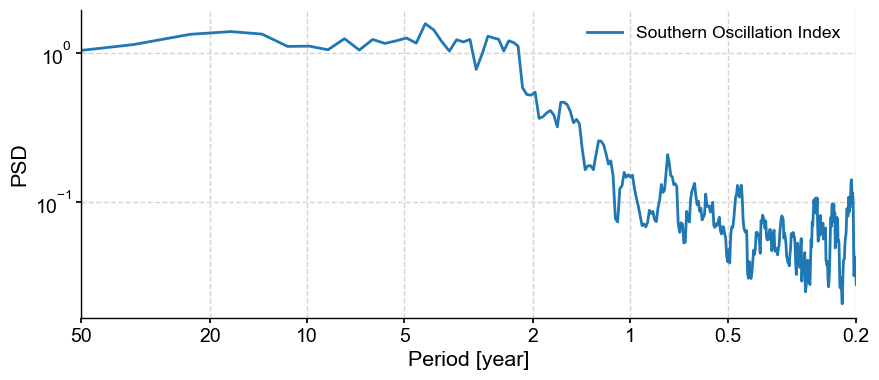

In [8]:
SOI = pyleo.utils.load_dataset('SOI')
psd = SOI.standardize().spectral(method='mtm')
psd.plot()

It looks like there are several peaks superimposed on what looks like a classical AR(1) background. The AR(1) surrogates would therefore be more appropriate to test the significance of such peaks. Let us visualize these surrogates:

In [9]:
pyleo.__version__

'1.1.1b0'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


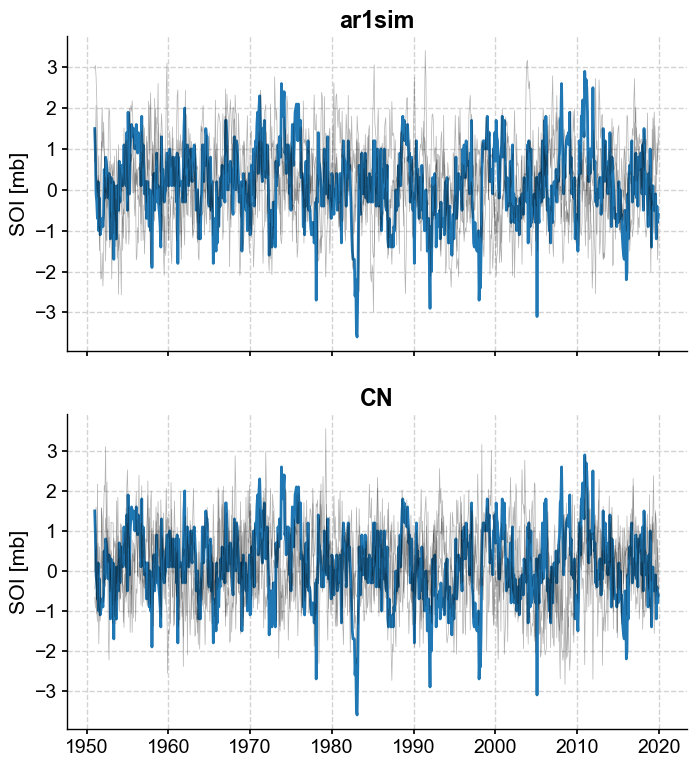

In [10]:
fig, axs = plt.subplots(2,1,figsize=(8,9),sharex=True)
axs = axs.flatten()
surr = {}
for i, method in enumerate(['ar1sim','CN']):
    surr[method] = pyleo.SurrogateSeries(method=method,number=3) 
    surr[method].from_series(SOI)
    surr[method].plot_traces(ax=axs[i],legend=False,num_traces=5,color='black')
    SOI.plot(ax=axs[i],legend=False)
    axs[i].set_title(method, fontweight='bold')
    if i<2:
        axs[i].set_xlabel(None)

It does seem like the colored noise surrogates are too smooth. Note that we can retrieve the model parameters rather simply:

In [11]:
surr['CN'].param

[0.5833208448587595]

This is a consequence of fitting a single spectral slope to a spectrum that clearly has several regimes: a flat one from scales of ~5 to 50 years, and a steeper one from 0.2y to 2y. The function [beta_est()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.psds.PSD.beta_est) can help us zero in on the slope in different ranges of frequencies (inverse of scales):

In [12]:
psd.beta_est(fmin=1/50, fmax=1/5).beta_est_res['beta']

0.09625868569645563

In [13]:
psd.beta_est(fmin=1/2, fmax=1/.2).beta_est_res['beta']

0.6893110814786663

One could fit a more elaborate noise model with several spectral regimes, but it becomes hard to justify this on physical grounds, unless one has a mechanistic model that behaves this way. 

### Uses for significance testing
Let us look at the consequences of choosing either type of surrogate to evaluate the significance of spectral peaks. Several `Pyleoclim` objects or methods have associated significance tests, and for all those, the choice of the `method` parameter is simply the name of the surrogate. For instance, for [PSD](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.psds.PSD) objects: 

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:05<00:00, 171.79it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:07<00:00, 136.99it/s]


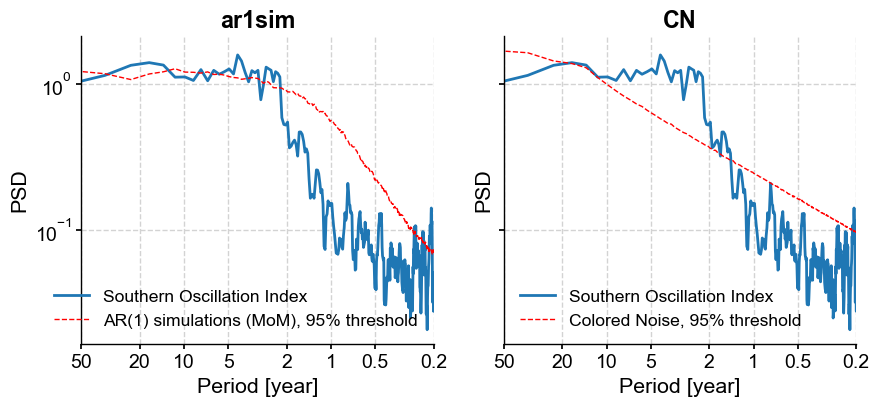

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,4),sharey=True)
axs = axs.flatten()
psd_s = {}
for i, method in enumerate(['ar1sim','CN']):
    psd_s[method] = psd.signif_test(method=method,number=1000)
    psd_s[method].plot(ax=axs[i])
    axs[i].set_title(method, fontweight='bold')

We see that both surrogate methods would gauge the interannual peak as significant. The peak around 20y, however, is significant with respect to the AR(1) benchmark, but not the colored noise benchmark (at the 95% level). Subannual peaks are insignificant with respect to either benchmark.


## Non-parametric surrogates

The previous example illustrates the drawback of parametric modeling: when there is no clear model to use as a null, it may be difficult to choose an appropriate one, and the choice clearly affects the results. An alternative is to use non-parametric models, as mentioned in the introduction. Here we discuss the case of [phase randomization](https://doi.org/10.1103/PhysRevLett.73.951), implemented as `phaseran` in `Pyleolim`.

### Phase randomization and correlations

In a seminal paper, [Ebusizaki (1997)](http://dx.doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2) introduced the idea of phase randomization to test the significance of correlations. If you look at the [tutorial on correlations](./L2_correlations.md), you will see that correlations far greater than 0 can easily arise between series that are "warm-colored", in the sense that their spectrum shows more energy at long timescales (low frequencies) than short timescales (high frequencies), as SOI does, along with a large majority of climate and paleoclimate time series.

For instance, the LR04 benthic stack:


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

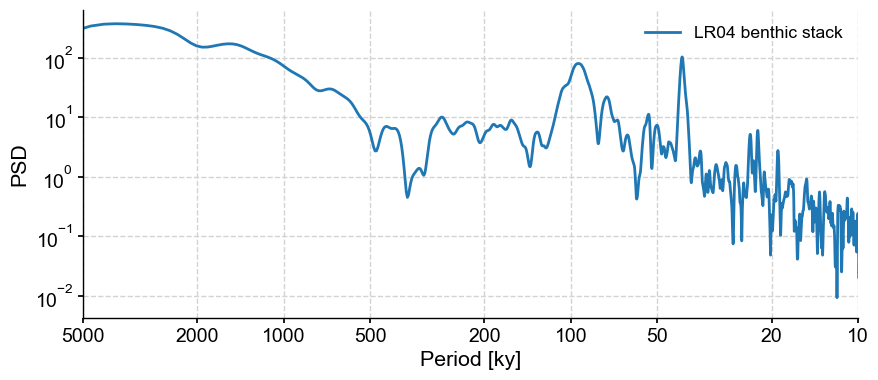

In [15]:
LR04 = pyleo.utils.load_dataset('LR04')
LR04_ls = LR04.spectral()
LR04_ls.plot()

There is no easy parametric fit to this series. Instead, the idea of phase randomization is to generate surrogates that share the **same power spectrum** (amplitude of the sines and cosines that make up the timeseries, in Fourier's view) as the target series,  **but random phases**. The surrogates will have the same low-order moments as the target series (same mean, same variance, same [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation)), but the sequence of events will differ. Put another way, they'll show the same kind of wiggles (same amplitude, same periods) as the original, but the wiggles will be in different places. 

That way, when computing a correlation or a coherence between two series, one can use as benchmark a set of surrogates that share a lot of similarities with the original, but where phase relationships between the members of those ensembles are purely the result of chance. We can then computee the statistic of interest (e.g. Pearson's correlation) and see how it fares compared to the distribution of correlations obtained between pairs of such surrogates. If the correlation (say 0.38) falls within the normal range of values for those pairs (say, lower than the 95th percentile), one would conclude that there is nothing exceptional about a correlation of 0.38, given the characteristics of the series. If, on the other hand, the correlation falls in the very tails of the distribution (say, higher than the 95th or even 99th percentile), then you would have very strong grounds to claim that the result is **significant**. 

Let us look at the properties of phase-randomized surrogates of the LR04 record. Note that this series is unevenly spaced, which you can gauge by applying the [resolution()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.resolution) function:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='resolution [ky BP]'>)

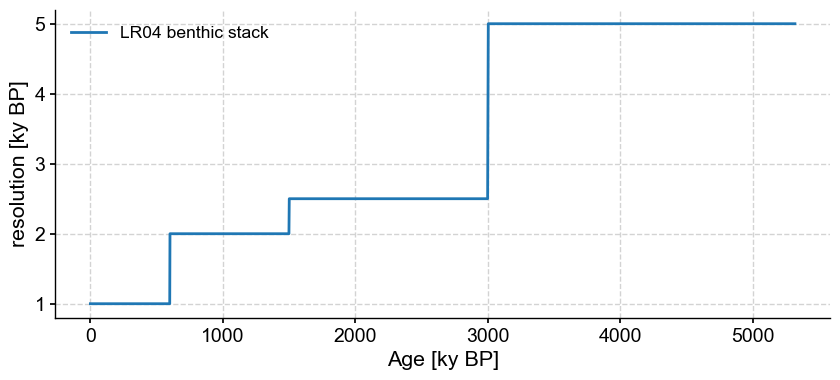

In [16]:
LR04.resolution().plot()

As of now May 2024, phase randomization in `Pyleoclim` is only possible for evenly-spaced series, so we interpolate it with 2ky increments, and limit our analysis to the Pleistocene (the past ~900ky) to better see what is going on:

In [17]:
LR04_2k = LR04.slice([0,900]).interp(step=2) # why is sel() not doing anything??
psd = LR04_2k.spectral(method='mtm',settings={'NW':3}) 

Next, we generate LR04 surrogates. To enable comparisons between different kinds of surrogates, let us write a little function to easily apply computations and visualizatons to 3 different knds of surrogates. 

In [18]:
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
import seaborn as sns

def LR04_surr_viz(method='phaseran', nsurr = 200):

    surr = pyleo.SurrogateSeries(method=method,number=nsurr)
    surr.from_series(LR04_2k)
    
    # EnsembleSeries correlation should allow an option without signif_test
    corr = np.empty((nsurr))
    for k, ts in enumerate(surr.series_list):
        corr[k] = pearsonr(LR04_2k.value,ts.value)[0]
    
    # compute spectra
    psd_surr =  surr.spectral(method='mtm',settings={'NW':3}) 
    
    # make the figure
    fig = plt.figure(tight_layout=True,figsize=(8,6))
    ax = {}
    gs = gridspec.GridSpec(2, 2)
    ax['ts'] = fig.add_subplot(gs[0, :])
    surr.plot_traces(ax=ax['ts'],num_traces=5,color='black') # plot_legend argument does not work; also called "legend" in plot() ; should have consistent terminology
    LR04_2k.plot(ax=ax['ts'],legend=False,invert_yaxis=True,
                 title=f'Pleistocene LR04 and surrogates ({method})')
    # plot spectra
    ax['spec'] = fig.add_subplot(gs[1, 0])
    psd_surr.plot_envelope(ax=ax['spec'],plot_legend=False,curve_clr='gray',
                           members_plot_num=0,shade_clr='silver')
    psd.plot(ax=ax['spec'], title='MTM spectra')
    # plot correlations
    ax['corr'] = fig.add_subplot(gs[1, 1])
    sns.histplot(corr,ax=ax['corr'],kde=True,color='gray')
    ax['corr'].set_xlabel(r'$r(surr,LR04)$')
    ax['corr'].set_title('Correlations')


Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:00<00:00, 314.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


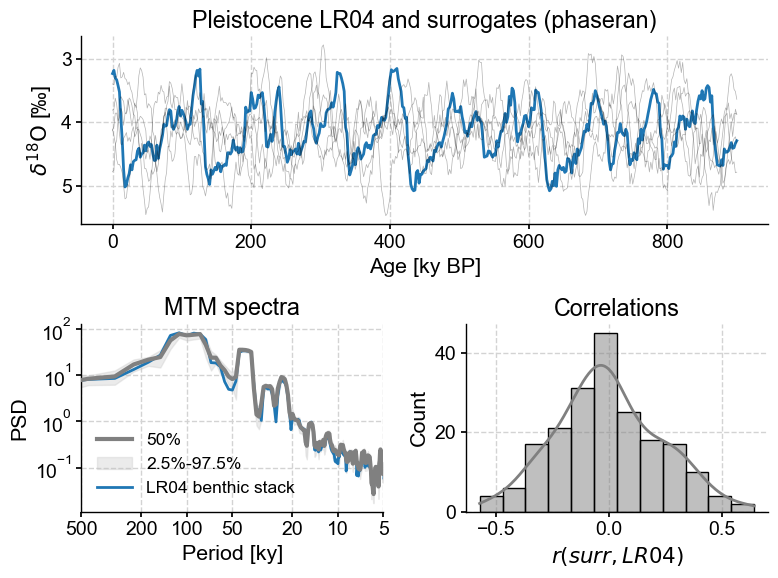

In [19]:
LR04_surr_viz()

The top panel shows the original trace and its surrogates. As promised, they show similar wiggles, but in different places. The lower left panel, and shows that all surrogates have a spectrum that is virtually identical to that of LR04 (it would be identical if we had infinitely many samples). On the lower right is a histogram of correlations between the target and the phase-randomized surrogates. It is symmetric and centered around 0, which one would expect. More surprisingly, while correlations of $\pm0.5$ are relatively rare, they are not unheard of. That means we can't claim that a correlation of 0.38 with LR04, for instance, is all that remarkable ("significant"). 

Let us now compare this to the colored noise (CN) surrogates:

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:00<00:00, 232.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


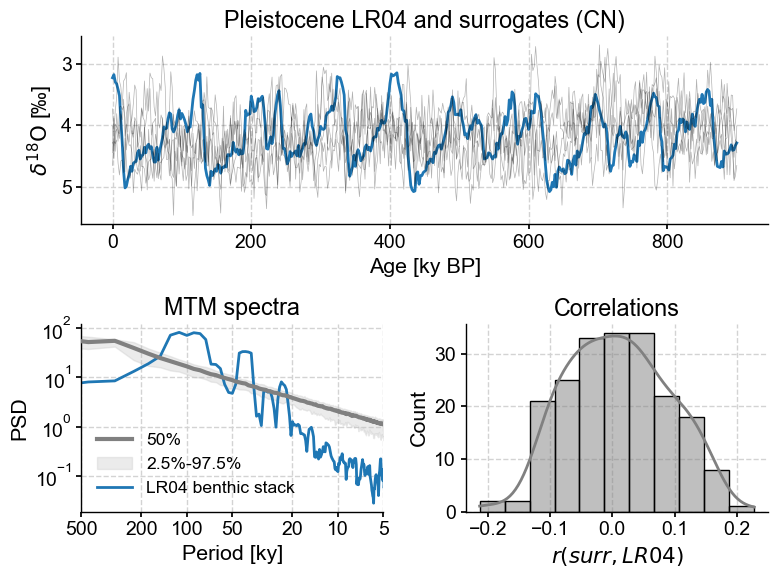

In [20]:
LR04_surr_viz(method='CN')

Here we see that the method fit the slope to the entire spectrum, so it is rather flat, and the surrogates are not terribly convincing emulations of the LR04 stack. What about AR(1) surrogates? 

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:00<00:00, 291.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


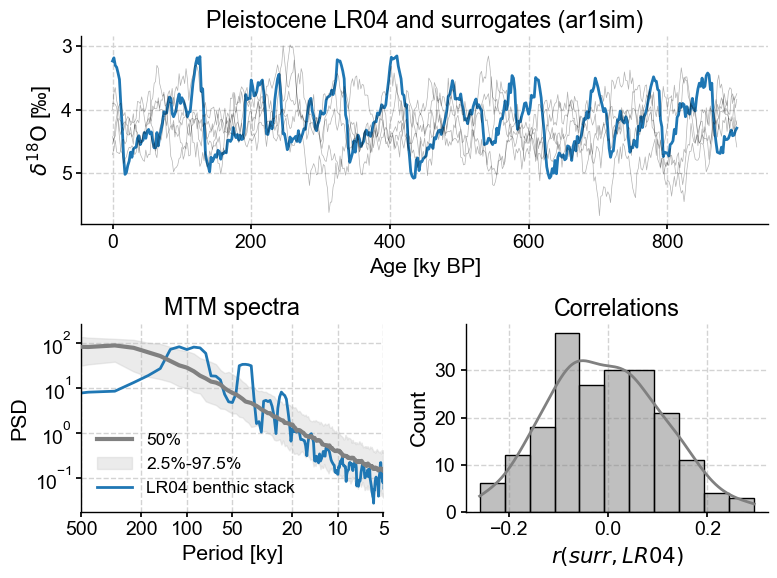

In [21]:
LR04_surr_viz(method='ar1sim')

AR(1) surrogates appear more appropriate here. 

## Unevenly-spaced surrogates

Lastly, we finish by noting that both the `ar1sim` and `CN` options allow for unevenly-spaced patterns. That is, they match the temporal pattern of observations of the original series. For instance, generating AR(1) surrogates and plotting their resolution shows that it matches the original: 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Surrogates'}, xlabel='Age [ky BP]', ylabel='resolution [ky BP]'>)

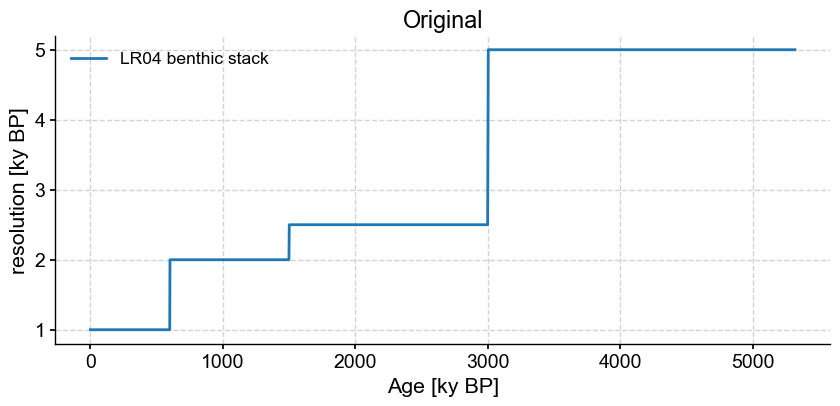

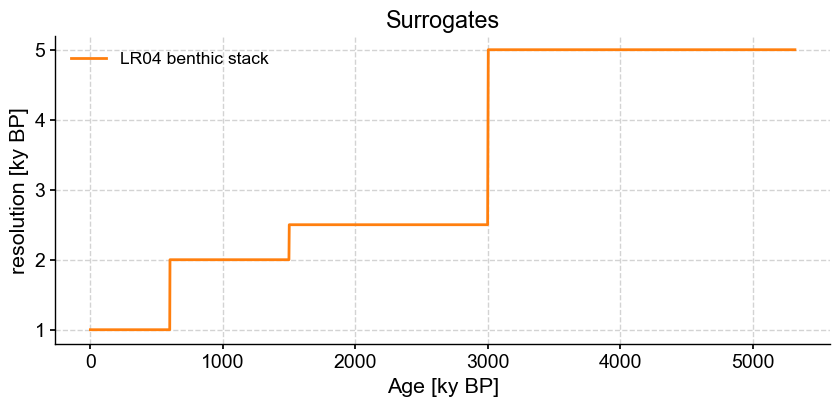

In [22]:
LR04_ar1 = pyleo.SurrogateSeries(method='ar1sim',number=1)
LR04_ar1.from_series(LR04) 
LR04.resolution().plot(title='Original')
LR04_ar1.series_list[0].resolution().plot(color='C1',title='Surrogates')

Finally, you can use these surrogates to test all kinds of things. For instance, if you wanted to assess the significance of the spectral peaks in LR04 with respect to an AR(1) benchmark, you would do:

In [23]:
LR04_ls_sig = LR04_ls.signif_test(method='ar1sim',number=200)

Performing spectral analysis on individual series: 100%|██████████| 200/200 [01:22<00:00,  2.41it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

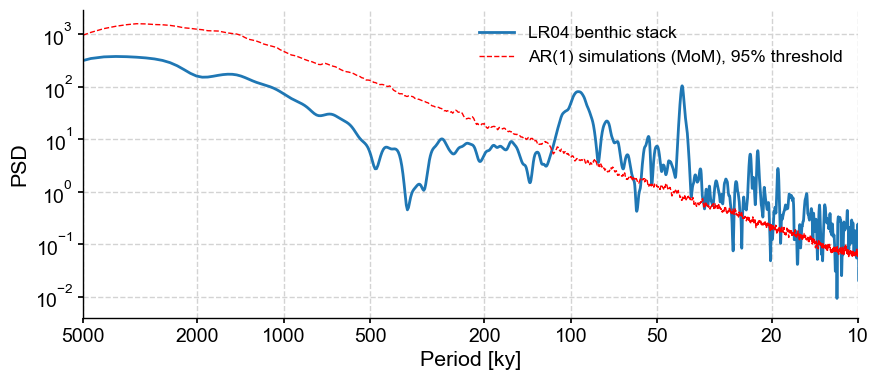

In [24]:
LR04_ls_sig.plot()

If you wanted to use a colored noise benchmark, all you would change is `method = 'CN'` in the call above. However, we just saw that it is not a particularly convincing model for this series, so that would be ill-advised.

## Takeways

- Surrogates are the basis of most non-parametric tests, particularly anything colloquially labeled "Monte Carlo". 
- `Pyleoclim` has multiple ways of generating surrogates
- They can be used to assess the significance of various results, like spectral peaks, correlations, or wavelet coherence